In [1]:
using Pkg
Pkg.instantiate()
Pkg.add("MCMCChains")
Pkg.add("DataFrames")
Pkg.add("Gadfly")
using TAMode
using LinearAlgebra
using Gadfly
using DataFrames

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %          ]  71.4 %Fetching: [===================================>     ]  85.7 %

  Resolving package versions...
No Changes to `~/TAMode.jl/Project.toml`
No Changes to `~/TAMode.jl/Manifest.toml`
  Resolving package versions...
No Changes to `~/TAMode.jl/Project.toml`
No Changes to `~/TAMode.jl/Manifest.toml`
  Resolving package versions...
No Changes to `~/TAMode.jl/Project.toml`
No Changes to `~/TAMode.jl/Manifest.toml`
┌ Info: Precompiling TAMode [294f26d0-a9c2-4f6a-959f-92a060cb6778]
└ @ Base loading.jl:1278


In [2]:
using MCMCChains
chn = read("chain-file-6_26.jls", Chains)
summarize(chn)

Summary Statistics
     parameters     mean     std  naive_se    mcse      ess   r_hat
  ─────────────  ───────  ──────  ────────  ──────  ───────  ──────
        AXLexpr  24.4652  1.7037    0.1078  0.6163   7.8061  1.1169
         Ig2rev   0.1308  0.1487    0.0094  0.0749   5.4740  1.1725
         gasCur   0.2270  0.2220    0.0140  0.1124   5.3856  1.1841
    internalize   0.0453  0.0114    0.0007  0.0048   7.2654  1.1545
           kDeg   0.0235  0.0072    0.0005  0.0045   4.9615  1.2561
           kRec   0.0900  0.0580    0.0037  0.0296   5.8971  1.1813
  pYinternalize   1.0769  0.1129    0.0071  0.0348  15.5465  1.0517
          scale   0.0302  0.0115    0.0007  0.0071   4.7714  1.2904
      scaleSurf   0.0002  0.0002    0.0000  0.0001   5.3632  1.1732
          sortF   0.2971  0.0234    0.0015  0.0117   3.8863  1.5341
           xFwd   0.0011  0.0039    0.0002  0.0014   5.9949  1.0791


In [7]:
Ig2rev = get(chn, :Ig2rev)[1]
scale = get(chn, :scale)[1]
scaleSurf = get(chn, :scaleSurf)[1]

x = get(chn, [:internalize, :pYinternalize, :sortF, :kRec, :kDeg, :xFwd, :gasCur, :AXLexpr]);
samp_params = hcat(x.internalize, x.pYinternalize, x.sortF, x.kRec, x.kDeg, x.xFwd, x.gasCur);

In [119]:
tps = range(0.0, 1440, length=200)
index = 201
# M0
AXLexpr = 15.5
MerTKexpr = 55
Tyro3expr = 3.7
params = vcat(samp_params[index, :], AXLexpr, MerTKexpr, Tyro3expr, Ig2rev[index], [1.0, 1.0, 1.8, 100.0]);

In [120]:
pYAXL = TAMode.pY .* TAMode.recpSpecific[1]
surfAXL = TAMode.surface .* TAMode.recpSpecific[1]
totAXL = TAMode.total .* TAMode.recpSpecific[1]

pYMerTK = TAMode.pY .* TAMode.recpSpecific[2]
surfMerTK = TAMode.surface .* TAMode.recpSpecific[2]
totMerTK = TAMode.total .* TAMode.recpSpecific[2]

pYTyro3 = TAMode.pY .* TAMode.recpSpecific[3]
surfTyro3 = TAMode.surface .* TAMode.recpSpecific[3]
totTyro3 = TAMode.total .* TAMode.recpSpecific[3];

data = TAMode.runTAM(tps, params, 10);

In [121]:
pYA = (data * pYAXL) * scale[index]
surfA = (data * surfAXL) * scaleSurf[index]
totalA = (data * totAXL) # 4067.2585803887146

pYM = (data * pYMerTK) * scale[index]
surfM = (data * surfMerTK) * scaleSurf[index]
totalM = (data * totMerTK) # 85.86830649771866

pYT = (data * pYTyro3) * scale[index]
surfT = (data * surfTyro3) * scaleSurf[index]
totalT = (data * totTyro3); # 440.6731445966876
println(totalM[1])
println(totalA[1])
println(totalT[1])

8480.415187244163
1420.243256459686
745.1883113619709


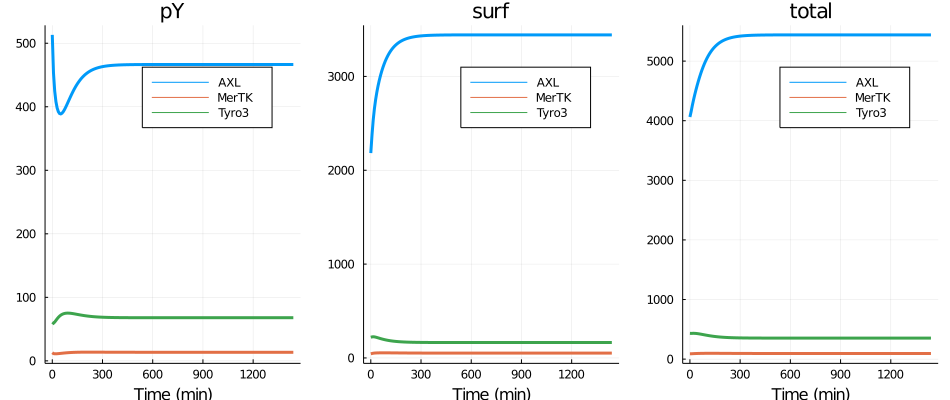

In [3]:
AXLexpr = 45
MerTKexpr = 0.7
Tyro3expr = 3.3
TAMode.plotTimeSeries(chn, AXLexpr, MerTKexpr, Tyro3expr)

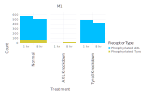

In [4]:
TAMode.plotpYExpression(chn, AXLexpr, MerTKexpr, Tyro3expr, "M1")